C:\Users\Administrator\AppData\Local\Temp\ipykernel_13168\4157610984.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_data['Predicted_Power'] = base_predictions + variation
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13168\4157610984.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_data['Predicted_Power'] = future_data['Predicted_Power'].clip(


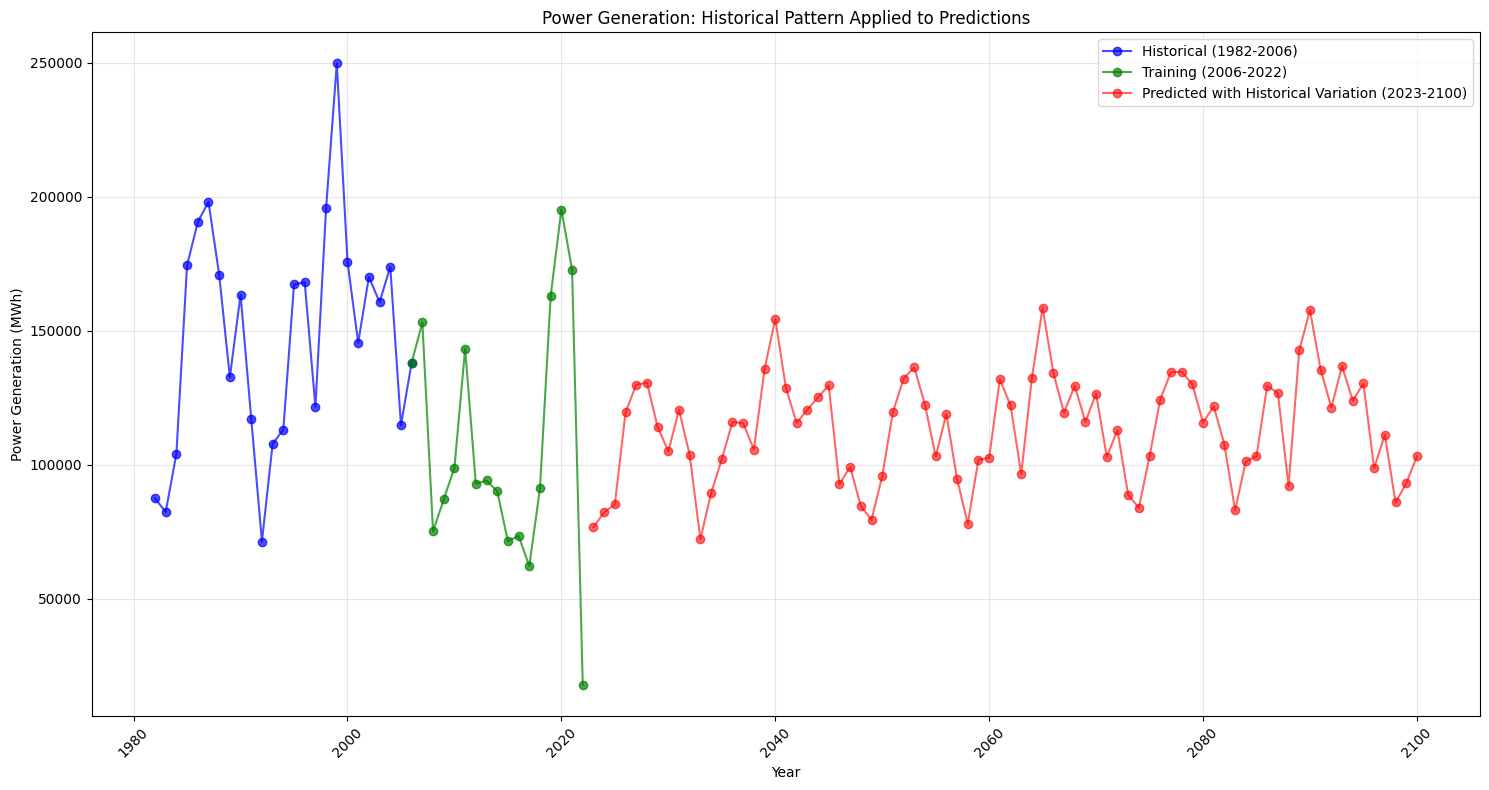


Model Statistics:
Historical Mean (1982-2006): 147729.08 MWh
Historical Std (1982-2006): 42317.06 MWh
R² Score: 0.012


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression



# Read the data

folder_path = r'F:\work\rudra sir\my_work\for_final'
raw_pg= pd.read_excel(os.path.join(folder_path, "raw_pg.xlsx"))
discharge_data = pd.read_csv('bias_corrected_discharge_with_trend.csv')







# Calculate annual discharge
annual_discharge = discharge_data.groupby('Year')['another_Bias_Corrected_Discharge'].sum().reset_index()

# Get historical statistics (1982-2006)
historical_pg = raw_pg[(raw_pg['Date'] >= 1982) & (raw_pg['Date'] <= 2006)]
historical_mean = historical_pg['Power_generation'].mean()
historical_std = historical_pg['Power_generation'].std()

# Calculate historical variability pattern
historical_pattern = (historical_pg['Power_generation'] - historical_mean) / historical_std

# Prepare training data (2006-2022)
training_data = pd.merge(
    raw_pg[raw_pg['Date'] >= 2006],
    annual_discharge[annual_discharge['Year'] <= 2022],
    left_on='Date',
    right_on='Year',
    how='inner'
)

# Create and fit linear regression model
model = LinearRegression()
X_train = training_data[['another_Bias_Corrected_Discharge']]
y_train = training_data['Power_generation']
model.fit(X_train, y_train)

# Make base predictions
future_data = annual_discharge[annual_discharge['Year'] >= 2023]
base_predictions = model.predict(future_data[['another_Bias_Corrected_Discharge']])

# Apply historical bias correction and variability
np.random.seed(42)  # for reproducibility
n_years = len(future_data)
n_historical = len(historical_pattern)

# Create cyclic pattern by repeating historical pattern
repeated_pattern = np.tile(historical_pattern, (n_years // n_historical + 1))[:n_years]
variation = repeated_pattern * historical_std * 0.5  # Scale factor 0.5 to reduce variation magnitude

# Apply correction and variation
future_data['Predicted_Power'] = base_predictions + variation

# Ensure predictions stay within reasonable bounds
future_data['Predicted_Power'] = future_data['Predicted_Power'].clip(
    lower=historical_mean - 2*historical_std,
    upper=historical_mean + 2*historical_std
)

# Plotting
plt.figure(figsize=(15, 8))

# Plot historical period
plt.plot(historical_pg['Date'], historical_pg['Power_generation'],
         'o-', label='Historical (1982-2006)', color='blue', alpha=0.7)

# Plot training period
plt.plot(training_data['Date'], training_data['Power_generation'],
         'o-', label='Training (2006-2022)', color='green', alpha=0.7)

# Plot predictions with variation
plt.plot(future_data['Year'], future_data['Predicted_Power'],
         'o-', label='Predicted with Historical Variation (2023-2100)', 
         color='red', alpha=0.6)

plt.title('Power Generation: Historical Pattern Applied to Predictions')
plt.xlabel('Year')
plt.ylabel('Power Generation (MWh)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print statistics
print("\nModel Statistics:")
print(f"Historical Mean (1982-2006): {historical_mean:.2f} MWh")
print(f"Historical Std (1982-2006): {historical_std:.2f} MWh")
print(f"R² Score: {model.score(X_train, y_train):.3f}")



In [3]:
# Combine all power generation data into a single DataFrame
historical_data = pd.DataFrame({
    'Year': historical_pg['Date'],
    'Power': historical_pg['Power_generation'],
    'Period': 'Historical'
})

training_data_export = pd.DataFrame({
    'Year': training_data['Date'],
    'Power': training_data['Power_generation'],
    'Period': 'Training'
})

future_data_export = pd.DataFrame({
    'Year': future_data['Year'],
    'Power': future_data['Predicted_Power'],
    'Period': 'Future'
})

# Combine all periods
combined_data = pd.concat([historical_data, training_data_export, future_data_export])

# Sort by year
combined_data = combined_data.sort_values('Year').reset_index(drop=True)

# Export to CSV
combined_data.to_csv('complete_power_generation_timeline.csv', index=False)

print("Data exported successfully!")
print(f"Timeline covers years: {combined_data['Year'].min()} to {combined_data['Year'].max()}")
print(f"Total number of years: {len(combined_data)}")

Data exported successfully!
Timeline covers years: 1982 to 2100
Total number of years: 120
